<a href="https://www.kaggle.com/code/dsptlp/regression-with-timeline-data?scriptVersionId=167545282" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regression based on Stock Market
- Using regression to predict next day price based on a large window of previous days data
- If you enable GPU the final model will use it

In [1]:
!pip install --upgrade pyarrow
!pip install GPUtil

# Importing necessary packages
import os
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv
import lightgbm as lgb
import GPUtil

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
import xgboost as xgb

warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'logger_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

# Get the list of available GPUs
gpus = GPUtil.getGPUs()

if len(gpus) > 0:
    print("GPU(s) available:")
    gpu_ready = 1
    for gpu in gpus:
        print(f"- {gpu.name}")
else:
    print("No GPU available.")
    gpu_ready = 0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 34.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 15.0.0
    Uninstalling pyarrow-15.0.0:
      Successfully uninstalled pyarrow-15.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.1 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.2 which is incompatible.
  Preparing metadata (setup.py) ... - \ done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=aaf3df66f316e173f66707eecfb386e7ca27d4

## DEFINE FUNCTIONS

In [2]:
def get_prev_pane(df,y,index_col):
    df['prev_index'] = df[index_col] + y
    column_names = df.columns
    df_tmp = pd.merge(df, df, left_on=index_col, right_on='prev_index', how='inner', suffixes=("_"+str(y),''))
    df_tmp = df_tmp.drop(column_names,axis=1)
    df_tmp = df_tmp.drop(['prev_index'+"_"+str(y),index_col+"_"+str(y)],axis=1)
    return df_tmp

In [3]:
def load_data():

    # Reading the dataset
    dataset_path = "/kaggle/input/us-stock-market-2020-to-2024/US Stock Market Dataset.csv"

    try:
        # Attempt to read the dataset
        df = pd.read_csv(dataset_path)
        logger.info(f"Dataset loaded successfully from {dataset_path}")
    except FileNotFoundError:
        logger.error("Error: Dataset file not found. Please provide the correct file path.")
    except Exception as e:
        logger.error(f"An error occurred: {e}")

    # Rename the first column
    df = df.rename(columns={df.columns[0]: 'date_index'})

    df = df[['date_index','Natural_Gas_Price','Natural_Gas_Vol.','Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price' , 'Google_Vol.', 'Nvidia_Price',
           'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
           'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
           'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'    ]]

    # Remove all commas
    df = df.replace(',','', regex=True)

    df['prev_index'] = df['date_index'] + 1
    
    return df    

In [4]:
def create_panel(window_back,df):
    for i in range (0,window_back,1):
        prev_df = get_prev_pane(df,i,'date_index')
        if i == 0:
            final_df = prev_df
        else:
            final_df = pd.merge(final_df, prev_df, left_index=True, right_index=True)

    final_df = final_df.iloc[:-window_back]
    return final_df    

In [5]:
def model_data(final_df):
    col_names = final_df.columns[1:].tolist()

    # creating a copy of df
    df1 = final_df.fillna(0)

    #target column name
    label_name = 'Natural_Gas_Price_0'

    # defining the features and target
    X = df1.drop([label_name],axis=1)
    y = df1[[label_name]]

    # instantiating the scaler
    scaler = RobustScaler()

    # scaling the continuous featuree
    X[col_names] = scaler.fit_transform(X[col_names])

    # Get centering and scaling values for each feature
    centering = scaler.center_
    iqrs  = scaler.scale_

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)    
    
    return X_train, X_test, y_train, y_test, centering, iqrs

# BASELINE MODELS

In [6]:
window_back = 2
df = load_data()   
final_df = create_panel(window_back,df)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test, centering, iqrs = model_data(final_df)

In [7]:
# Defining a dictionary of regression models
regressors = {
    'AdaBoostRegressor': AdaBoostRegressor(),
    'LinearRegression': LinearRegression(n_jobs=-1),
    'KNeighborsRegressor': KNeighborsRegressor(n_jobs=-1),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=300, max_depth=1, subsample=0.8, max_features=0.2),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror', n_jobs=-1),
    'SVR': SVR(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'BayesianRidge': BayesianRidge()
}

AdaBoostRegressor CV Scores: [-0.08036669 -0.06947121 -0.05071438 -0.07193325 -0.05348318]
AdaBoostRegressor Mean Squared Error (MSE): 0.06980887764478783
AdaBoostRegressor Root Mean Squared Error (RMSE): 0.26421369692880764
AdaBoostRegressor Mean Absolute Error (MAE): 0.1921983364326432
AdaBoostRegressor R^2 Score: 0.9832450365727776


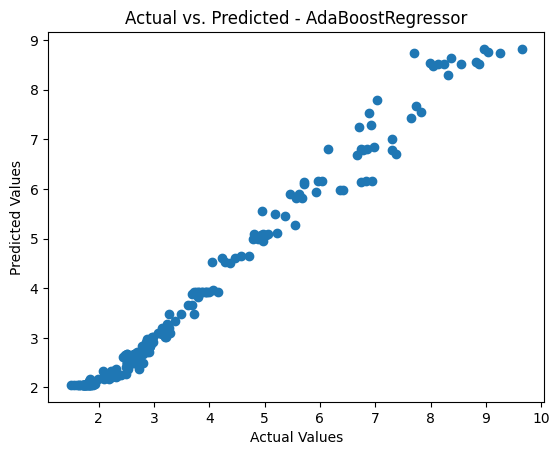

LinearRegression CV Scores: [-0.05274337 -0.05061002 -0.03322353 -0.05100098 -0.0353634 ]
LinearRegression Mean Squared Error (MSE): 0.045351648840259676
LinearRegression Root Mean Squared Error (RMSE): 0.21295926568304013
LinearRegression Mean Absolute Error (MAE): 0.14114233662655745
LinearRegression R^2 Score: 0.9891150632509915


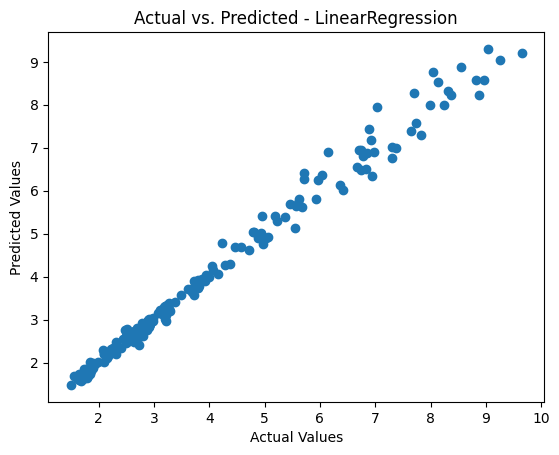

KNeighborsRegressor CV Scores: [-0.26346141 -0.28315597 -0.16613952 -0.24883125 -0.21461072]
KNeighborsRegressor Mean Squared Error (MSE): 0.2840220097029704
KNeighborsRegressor Root Mean Squared Error (RMSE): 0.53293715361473
KNeighborsRegressor Mean Absolute Error (MAE): 0.337319801980198
KNeighborsRegressor R^2 Score: 0.9318313294003405


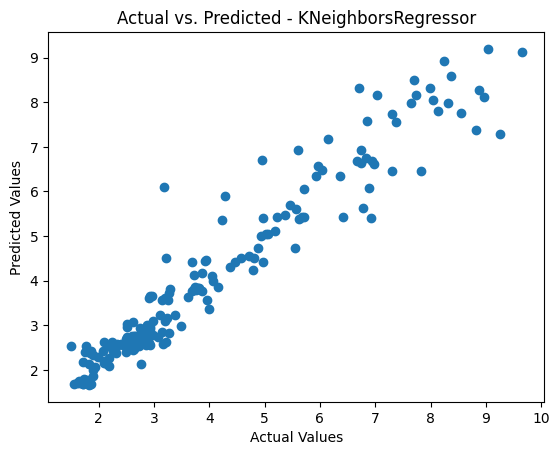

RandomForestRegressor CV Scores: [-0.06877182 -0.05581065 -0.03314629 -0.05664139 -0.04502789]
RandomForestRegressor Mean Squared Error (MSE): 0.05173724370544573
RandomForestRegressor Root Mean Squared Error (RMSE): 0.22745822408839328
RandomForestRegressor Mean Absolute Error (MAE): 0.14498361386138642
RandomForestRegressor R^2 Score: 0.9875824443057099


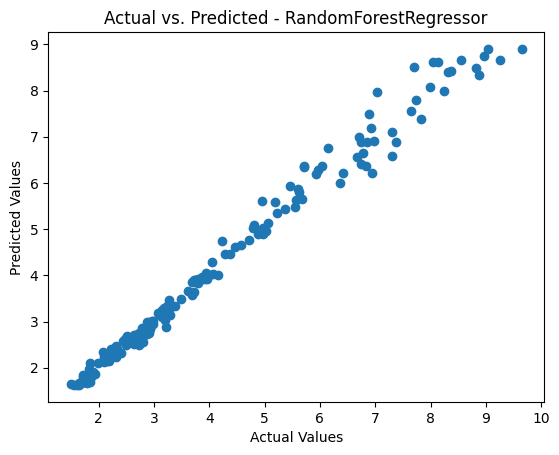

GradientBoostingRegressor CV Scores: [-0.19091517 -0.12455447 -0.16068622 -0.09447521 -0.12629001]
GradientBoostingRegressor Mean Squared Error (MSE): 0.18011976097346957
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.4244051849040838
GradientBoostingRegressor Mean Absolute Error (MAE): 0.3084228866135718
GradientBoostingRegressor R^2 Score: 0.9567691086084114


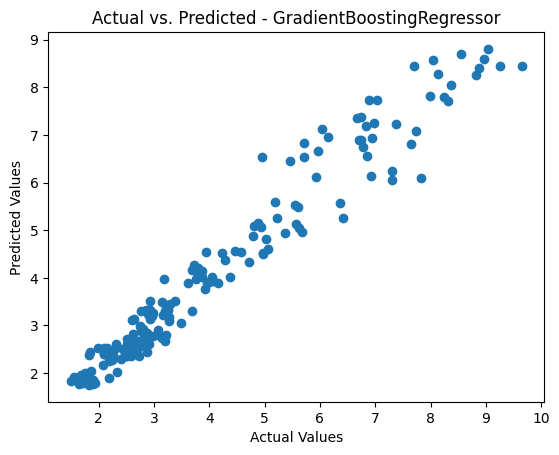

XGBRegressor CV Scores: [-0.08308862 -0.05576426 -0.0371557  -0.06262148 -0.06187395]
XGBRegressor Mean Squared Error (MSE): 0.06074799278048069
XGBRegressor Root Mean Squared Error (RMSE): 0.2464710789940286
XGBRegressor Mean Absolute Error (MAE): 0.15806942561121268
XGBRegressor R^2 Score: 0.9854197570330065


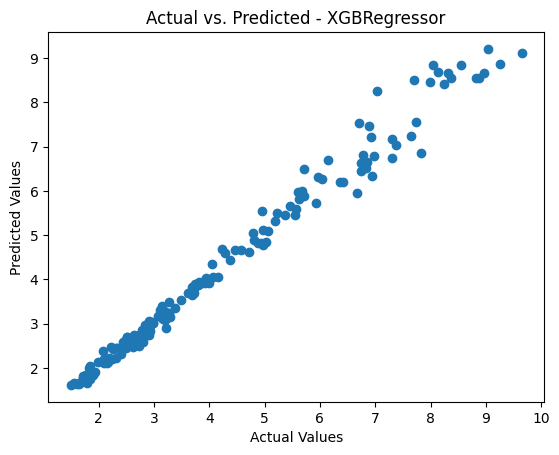

SVR CV Scores: [-0.16761621 -0.3263261  -0.15607272 -0.31055012 -0.26087781]
SVR Mean Squared Error (MSE): 0.13729602054380396
SVR Root Mean Squared Error (RMSE): 0.3705347764296949
SVR Mean Absolute Error (MAE): 0.25008809082254896
SVR R^2 Score: 0.9670473171819234


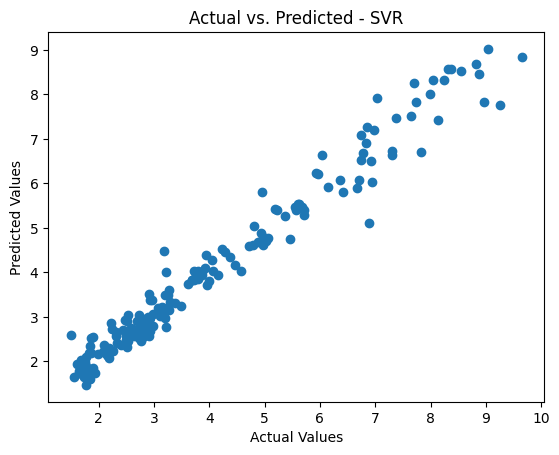

DecisionTreeRegressor CV Scores: [-0.10638843 -0.08792102 -0.06546927 -0.09848011 -0.10719224]
DecisionTreeRegressor Mean Squared Error (MSE): 0.07735252970297031
DecisionTreeRegressor Root Mean Squared Error (RMSE): 0.2781232275502539
DecisionTreeRegressor Mean Absolute Error (MAE): 0.18265841584158418
DecisionTreeRegressor R^2 Score: 0.9814344700860096


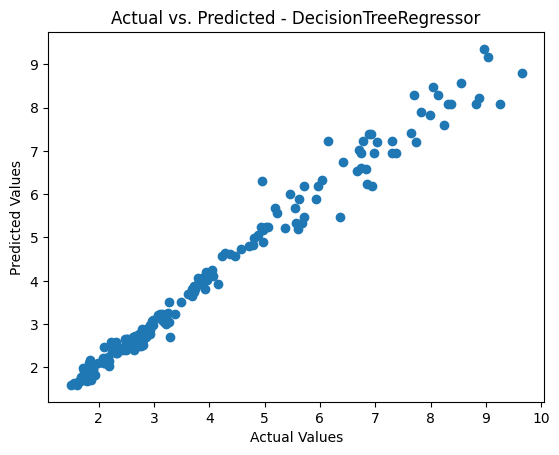

Lasso CV Scores: [-1.54999817 -2.03775498 -1.31523336 -1.45250987 -1.51715177]
Lasso Mean Squared Error (MSE): 1.76717915562183
Lasso Root Mean Squared Error (RMSE): 1.329352908606977
Lasso Mean Absolute Error (MAE): 1.0535981851644436
Lasso R^2 Score: 0.5758559208979885


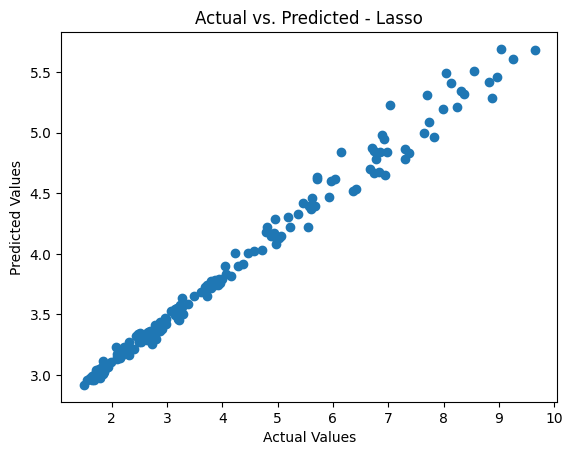

ElasticNet CV Scores: [-1.32253921 -1.67394222 -1.1395156  -1.21676906 -1.29601118]
ElasticNet Mean Squared Error (MSE): 1.4995246317241162
ElasticNet Root Mean Squared Error (RMSE): 1.2245507877275308
ElasticNet Mean Absolute Error (MAE): 0.9659595072320933
ElasticNet R^2 Score: 0.6400961996467137


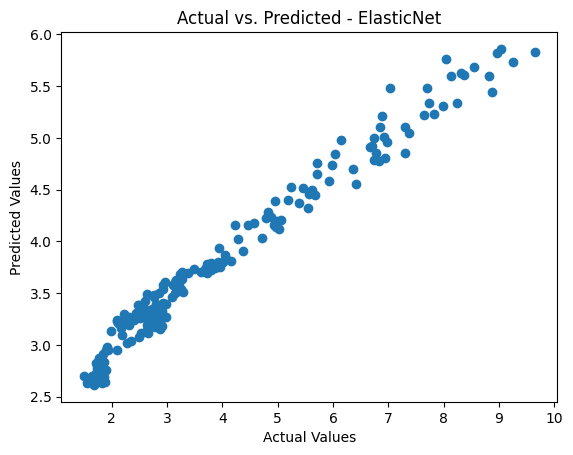

BayesianRidge CV Scores: [-0.05273495 -0.05069935 -0.03288374 -0.04939899 -0.03502589]
BayesianRidge Mean Squared Error (MSE): 0.04522667311324785
BayesianRidge Root Mean Squared Error (RMSE): 0.21266563688863288
BayesianRidge Mean Absolute Error (MAE): 0.14004241258799652
BayesianRidge R^2 Score: 0.9891450589163857


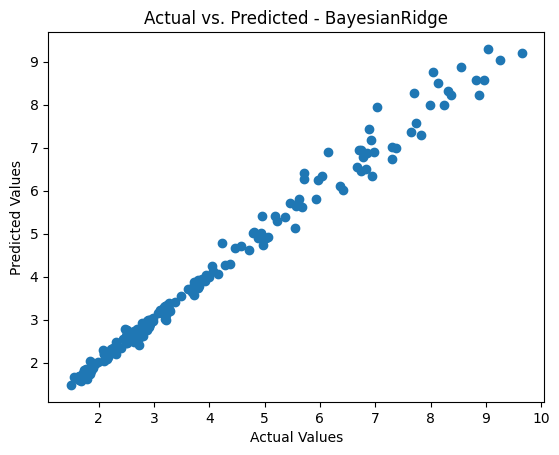

In [8]:
# Improved model evaluation and cross-validation for regression
model_results = []

# Looping through regression models and evaluating their performance
for name, model in regressors.items():
    try:
        logger.info(f"Training and evaluating {name} model.")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

        # Model training
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Evaluation metrics for regression
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})
        
        print("=============================================================================")
        print(name, "CV Scores:", cv_scores)
        print(name, "Mean Squared Error (MSE):", mse)
        print(name, "Root Mean Squared Error (RMSE):", rmse)
        print(name, "Mean Absolute Error (MAE):", mae)
        print(name, "R^2 Score:", r2)
        
        logger.info(f"{name} - CV Scores: {cv_scores}")
        logger.info(f"{name} - MSE: {mse}")
        logger.info(f"{name} - RMSE: {rmse}")
        logger.info(f"{name} - MAE: {mae}")
        logger.info(f"{name} - R^2 Score: {r2}")

        # Plotting the actual vs. predicted values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs. Predicted - {name}')
        plt.show()

    except Exception as ex:
        print(ex)
        logger.error(f"An error occurred while processing {name} model: {ex}")


## Model Results Baseline
- MSE is the one that we will use as MSE penalizes larger errors more heavily, which can be important in financial forecasting where large errors may have significant consequences.

In [9]:
df_results = pd.DataFrame(model_results)
df_results

,Model,MSE,RMSE,MAE,R^2,CV Scores
0,AdaBoostRegressor,0.069809,0.264214,0.192198,0.983245,"[-0.08036668727854872, -0.06947120768425706, -..."
1,LinearRegression,0.045352,0.212959,0.141142,0.989115,"[-0.05274337417864859, -0.050610022029783326, ..."
2,KNeighborsRegressor,0.284022,0.532937,0.337320,0.931831,"[-0.2634614135802469, -0.2831559681481482, -0...."
3,RandomForestRegressor,0.051737,0.227458,0.144984,0.987582,"[-0.06877181625679045, -0.05581065037037039, -..."
4,GradientBoostingRegressor,0.180120,0.424405,0.308423,0.956769,"[-0.19091516630846056, -0.12455447386832934, -..."
5,XGBRegressor,0.060748,0.246471,0.158069,0.985420,"[-0.08308861623439583, -0.05576425586931316, -..."
6,SVR,0.137296,0.370535,0.250088,0.967047,"[-0.16761621120164696, -0.32632609783863525, -..."
7,DecisionTreeRegressor,0.077353,0.278123,0.182658,0.981434,"[-0.1063884259259259, -0.08792101851851852, -0..."
8,Lasso,1.767179,1.329353,1.053598,0.575856,"[-1.5499981739122164, -2.037754975390863, -1.3..."
9,ElasticNet,1.499525,1.224551,0.965960,0.640096,"[-1.3225392142516825, -1.6739422156267318, -1...."


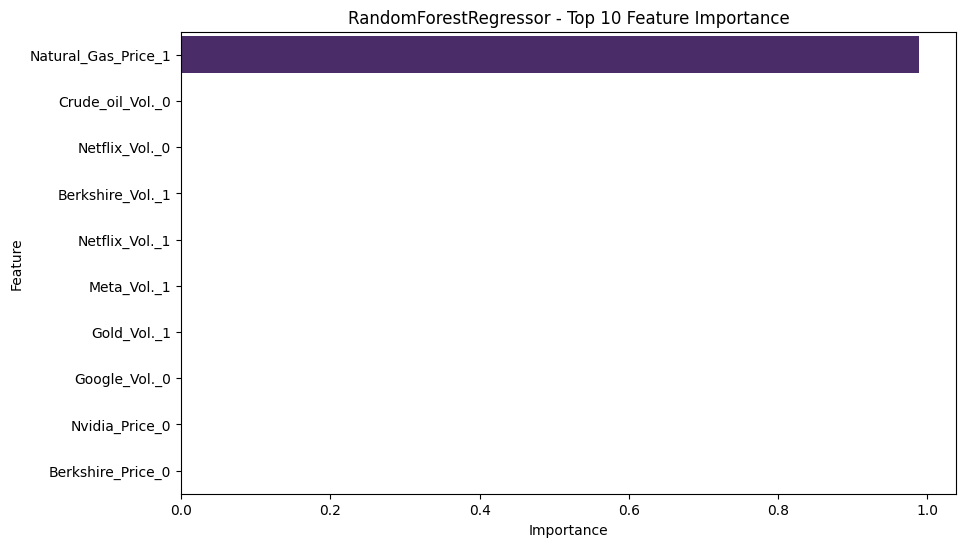

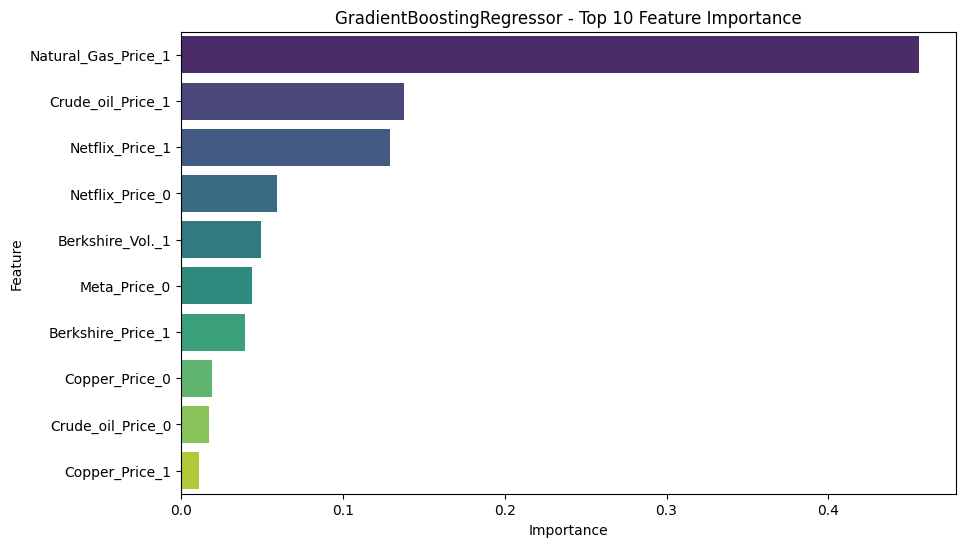

In [10]:
# Feature importance for tree-based models
for name, model in regressors.items():
    if isinstance(model, (RandomForestRegressor, GradientBoostingRegressor)):
        model.fit(X_train, y_train)
        feature_importances = model.feature_importances_
        feature_names = X_train.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        sorted_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # Display only the top 10 features
        top_10_features = sorted_df.head(10)
        
        # Create seaborn bar plot for the top 10 features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
        plt.title(f"{name} - Top 10 Feature Importance")
        plt.show()


## FINAL MODEL - LightGBM

In [11]:
window_back = 20
df = load_data()   
final_df = create_panel(window_back,df)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test, centering, iqrs = model_data(final_df)

In [12]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [100,300,500],
    'objective': ['regression'],
    'metric': ['mse'],
    'boosting_type': ['gbdt'],
    'is_enable_sparse': ['true'],        
    'max_drop': [1,10],       
    'learning_rate': [0.01,0.1],
    'feature_fraction': [1],
    'min_child_samples': [20],
    'min_child_weight': [1e-3],
    'max_depth': [-1],
    'num_iterations': [1000,2000,10000],
    'max_bin': [1000,2000,5000],
    'subsample': [1],
    'colsample_bytree': [1],
    'reg_alpha': [0.0],
    'reg_lambda': [0],
    'gpu_use_dp': ['true'],
    'verbosity': [-1]
}

callbacks = [lgb.early_stopping(50)]
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

if gpu_ready == 1:    
    param_grid['device'] = ['gpu']
    print("USING GPU")
else:    
    param_grid['device']  = ['cpu']
    print("USING CPU")
    
# Create a LightGBM model
lgb_model = lgb.LGBMRegressor(verbose=-1)

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(lgb_model, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display results for each parameter combination
results_df = pd.DataFrame(grid_search.cv_results_)
print("Grid Search Results:")
print(results_df[['params', 'mean_test_score', 'rank_test_score']])
print(results_df)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Make predictions on the test set
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration_)

# Evaluation metrics for regression
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=============================================================================")
print(name, "CV Scores:", cv_scores)
print(name, "Mean Squared Error (MSE):", mse)
print(name, "Root Mean Squared Error (RMSE):", rmse)
print(name, "Mean Absolute Error (MAE):", mae)
print(name, "R^2 Score:", r2)

model_results.append({'Model': 'Final_Model', 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': [0]})

USING CPU
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END boosting_type=gbdt, colsample_bytree=1, device=cpu, feature_fraction=1, gpu_use_dp=true, is_enable_sparse=true, learning_rate=0.01, max_bin=1000, max_depth=-1, max_drop=1, metric=mse, min_child_samples=20, min_child_weight=0.001, num_iterations=1000, num_leaves=100, objective=regression, reg_alpha=0.0, reg_lambda=0, subsample=1, verbosity=-1; total time=  19.4s
[CV] END boosting_type=gbdt, colsample_bytree=1, device=cpu, feature_fraction=1, gpu_use_dp=true, is_enable_sparse=true, learning_rate=0.01, max_bin=1000, max_depth=-1, max_drop=1, metric=mse, min_child_samples=20, min_child_weight=0.001, num_iterations=1000, num_leaves=100, objective=regression, reg_alpha=0.0, reg_lambda=0, subsample=1, verbosity=-1; total time=  19.2s
[CV] END boosting_type=gbdt, colsample_bytree=1, device=cpu, feature_fraction=1, gpu_use_dp=true, is_enable_sparse=true, learning_rate=0.01, max_bin=1000, max_depth=-1, max_drop=1, 

## Model Performance Graphs

X_train shape: (779, 359)
y_train shape: (779, 1)
X_test shape: (195, 359)
y_test shape: (195, 1)


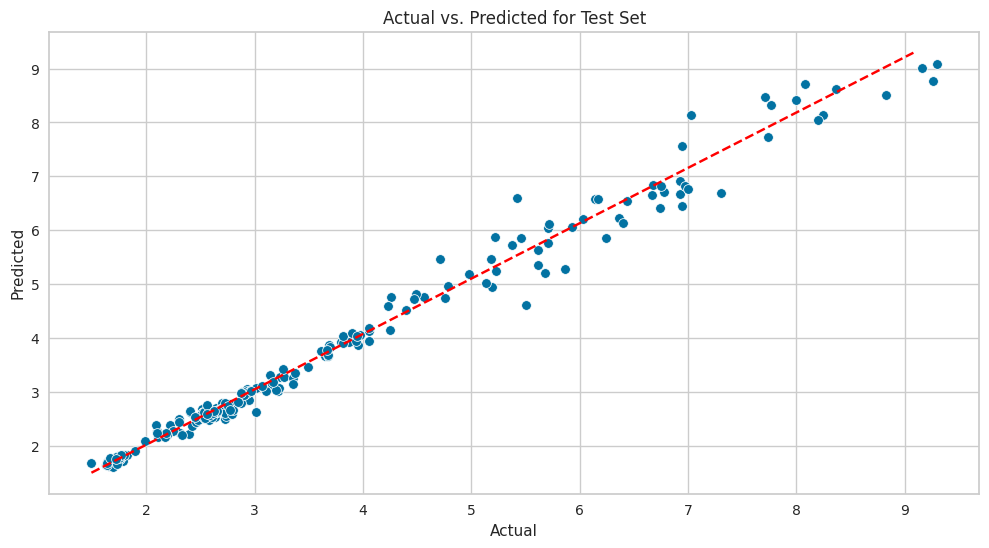

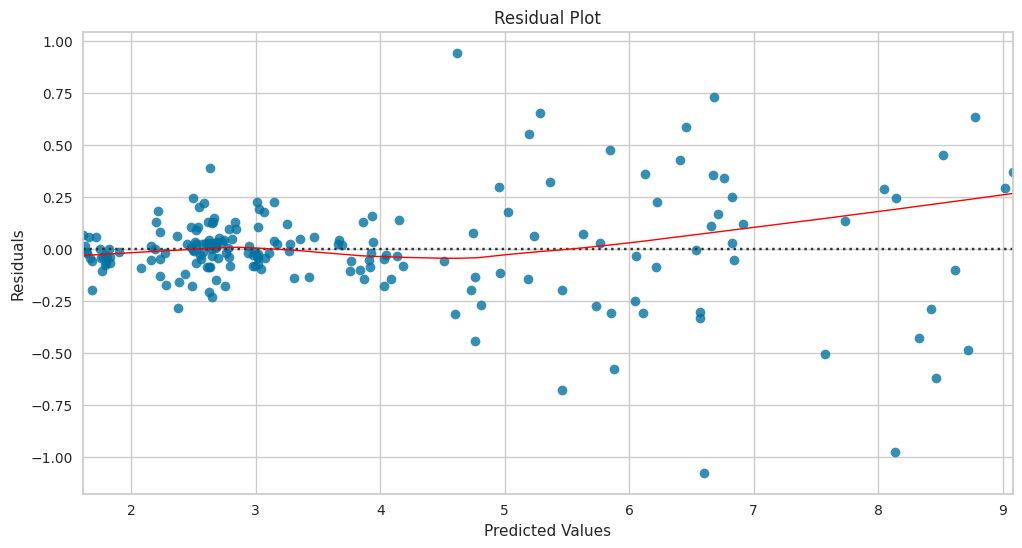

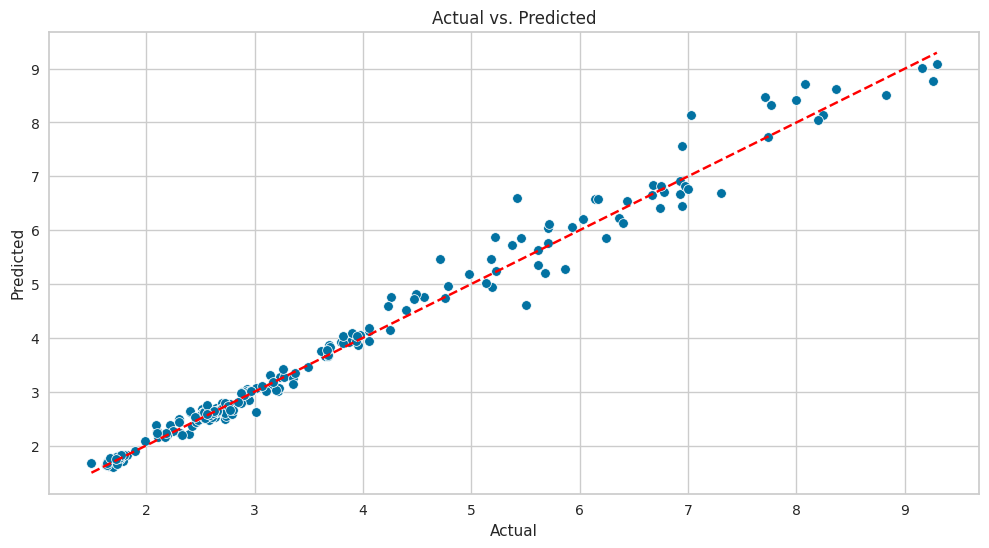

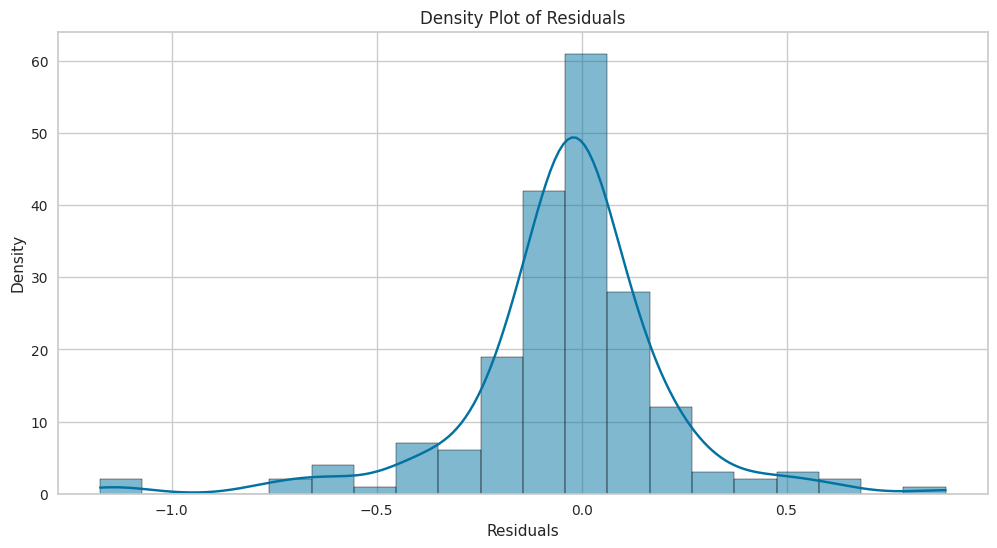

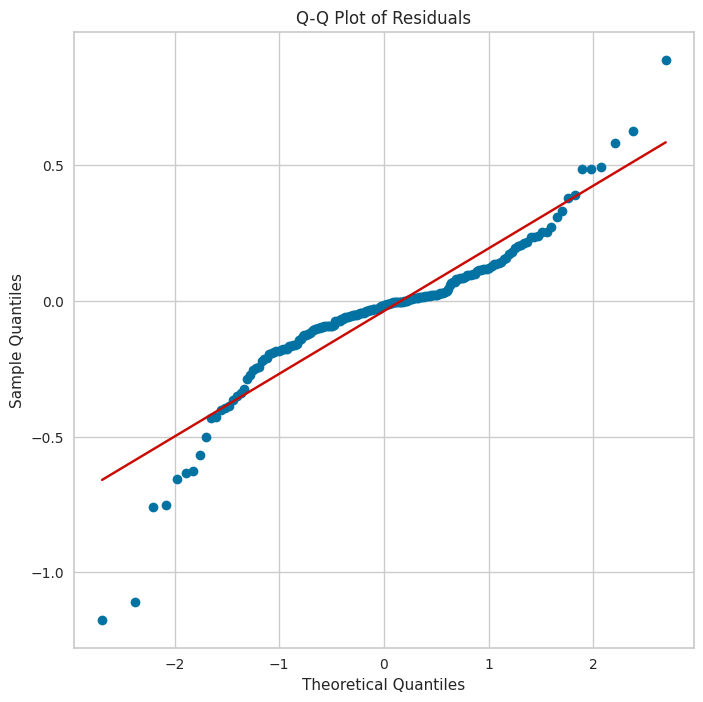

"\n# Prediction error plot\nvisualizer = PredictionError(lgb_model)\nvisualizer.fit(X_train, y_train)\nvisualizer.score(X_train, y_train)\nvisualizer.show()\n\n# Learning curve\nvisualizer = LearningCurve(lgb_model, scoring='r2')\nvisualizer.fit(X_train, y_train)\nvisualizer.show()\n\n# Feature importances plot\nplt.figure(figsize=(10, 6))\nviz = FeatureImportances(lgb_model)\nviz.fit(X_train, y_train)\nviz.show()\n"

In [13]:
from yellowbrick.regressor import ResidualsPlot, PredictionError
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import scipy.stats as stats

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Flatten the arrays
y_test_flat = y_test.values.flatten()
y_pred_flat = y_pred.flatten()

# Actual vs. Predicted plot for training set
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test_flat, y=y_pred_flat)
plt.plot([min(y_test_flat), max(y_pred_flat)], [min(y_test_flat), max(y_test_flat)], '--', color='red')
plt.title('Actual vs. Predicted for Test Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# Residual plot
residuals = y_test_flat - y_pred_flat
plt.figure(figsize=(12, 6))
sns.residplot(x=y_pred_flat, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Actual vs. Predicted plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test_flat, y=y_pred_flat)
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], '--', color='red')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# Density plot of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=20)
plt.title('Density Plot of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Q-Q plot of residuals
plt.figure(figsize=(8, 8))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

"""
# Prediction error plot
visualizer = PredictionError(lgb_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_train, y_train)
visualizer.show()

# Learning curve
visualizer = LearningCurve(lgb_model, scoring='r2')
visualizer.fit(X_train, y_train)
visualizer.show()

# Feature importances plot
plt.figure(figsize=(10, 6))
viz = FeatureImportances(lgb_model)
viz.fit(X_train, y_train)
viz.show()
"""

## Feature Importance

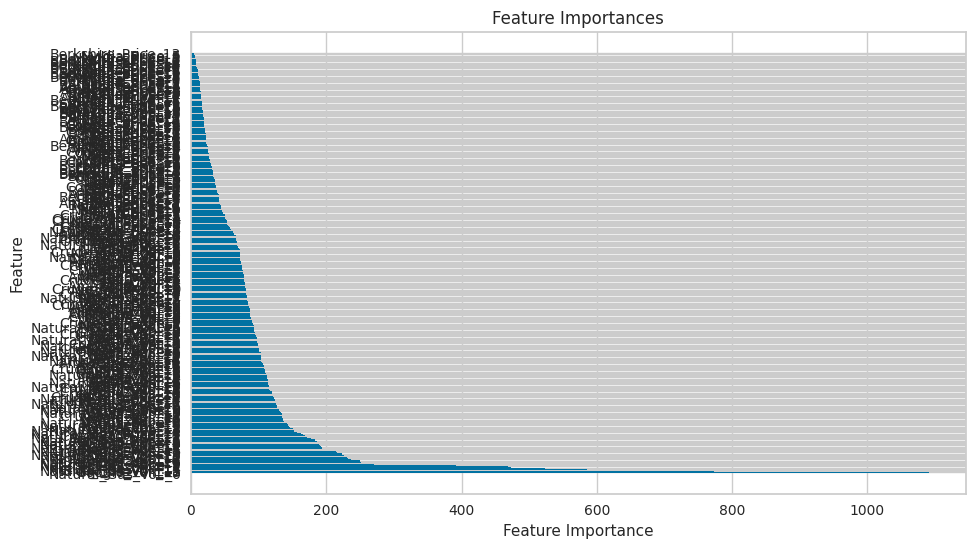

In [14]:
# Get feature importances
feature_importances = final_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort features based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

## Final Model Comparison

In [15]:
df_results = pd.DataFrame(model_results)
df_results

,Model,MSE,RMSE,MAE,R^2,CV Scores
0,AdaBoostRegressor,0.069809,0.264214,0.192198,0.983245,"[-0.08036668727854872, -0.06947120768425706, -..."
1,LinearRegression,0.045352,0.212959,0.141142,0.989115,"[-0.05274337417864859, -0.050610022029783326, ..."
2,KNeighborsRegressor,0.284022,0.532937,0.337320,0.931831,"[-0.2634614135802469, -0.2831559681481482, -0...."
3,RandomForestRegressor,0.051737,0.227458,0.144984,0.987582,"[-0.06877181625679045, -0.05581065037037039, -..."
4,GradientBoostingRegressor,0.180120,0.424405,0.308423,0.956769,"[-0.19091516630846056, -0.12455447386832934, -..."
5,XGBRegressor,0.060748,0.246471,0.158069,0.985420,"[-0.08308861623439583, -0.05576425586931316, -..."
6,SVR,0.137296,0.370535,0.250088,0.967047,"[-0.16761621120164696, -0.32632609783863525, -..."
7,DecisionTreeRegressor,0.077353,0.278123,0.182658,0.981434,"[-0.1063884259259259, -0.08792101851851852, -0..."
8,Lasso,1.767179,1.329353,1.053598,0.575856,"[-1.5499981739122164, -2.037754975390863, -1.3..."
9,ElasticNet,1.499525,1.224551,0.965960,0.640096,"[-1.3225392142516825, -1.6739422156267318, -1...."


In [16]:
# Save log messages to a file
# File handling: close the FileHandler
file_handler.close()
logger.removeHandler(file_handler)